# First things first

## 0. Import libraries

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.2.2+cpu
0.17.2+cpu


## 1. Get the data

In [3]:
train_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

### 1.1 Visualize data

In [4]:
image, label = train_data[0]
print(image, label)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [5]:
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [7]:
classes = train_data.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

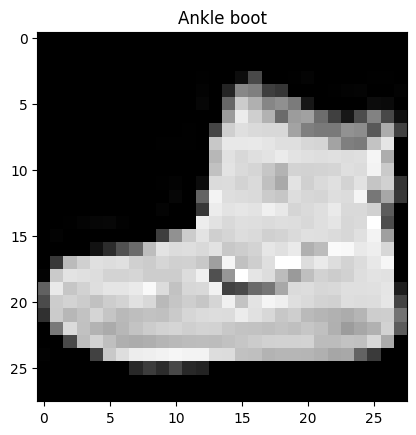

In [8]:
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(classes[label])

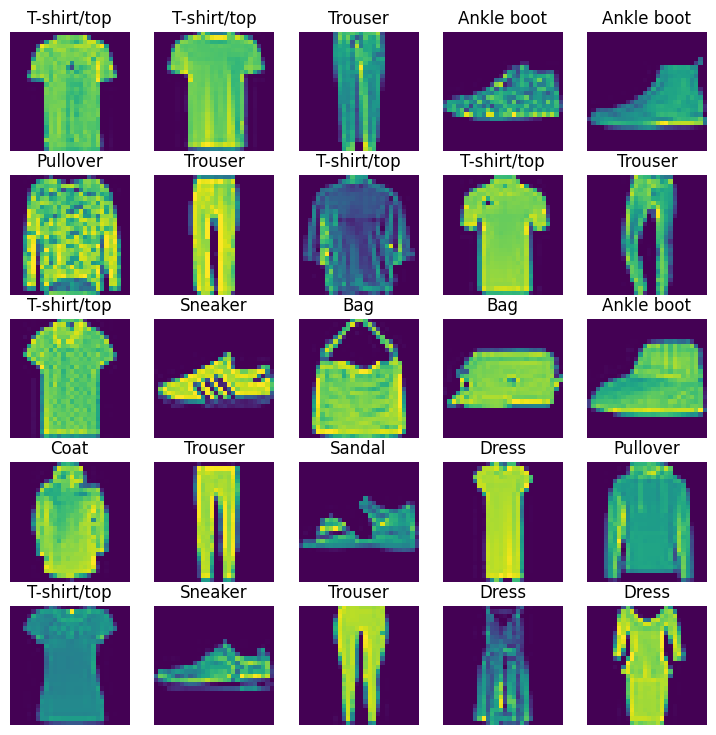

In [9]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 5, 5
for i in range(1, rows * cols + 1):
    j = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[j]
    fig.add_subplot(rows,cols,i)
    plt.imshow(image.squeeze())
    plt.title(classes[label])
    plt.axis(False)


## 2. Create DataLoader

In [10]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [11]:
xt_batch, yt_batch = next(iter(train_dataloader))

len(train_dataloader), len(test_dataloader), xt_batch.shape, yt_batch.shape

(1875, 313, torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [12]:
len(xt_batch[0]),len(xt_batch[1]),len(xt_batch[2])

(1, 1, 1)

In [13]:
xt_batch[0].shape, xt_batch[1].shape, xt_batch[2].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

## 3. Build model

### 3.1 Flatten layer

In [14]:
x0 = xt_batch[0]
flat = torch.nn.Flatten()
y0 = flat(x0)

print(f"before flattening : {x0.shape}")
print(f"after flattening : {y0.shape}")

before flattening : torch.Size([1, 28, 28])
after flattening : torch.Size([1, 784])


### 3.2 Baseline model

In [15]:
class SimpleFashionModule(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
model = SimpleFashionModule(
    input_shape=784,
    hidden_units=10,
    output_shape=len(classes)
)
model.to("cpu")

SimpleFashionModule(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### 3.3 Loss, Optimization and Metrics

In [17]:
loss = torch.nn.CrossEntropyLoss()

In [18]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [19]:
def accuracy(y, yp):
    correct = torch.eq(y, yp).sum().item()
    acc = (correct / len(yp)) * 100
    return acc

### 3.4 Timer

In [20]:
from timeit import default_timer as timer

In [21]:
def time(start: float, end: float):
    duration = end - start
    print(f"The event lasted {duration} seconds")
    return duration

### 3.5 Training

In [22]:
### tqdm is progress bar
from tqdm.auto import tqdm

epochs = 10

start = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_cost = 0
    for batch, (x,y) in enumerate(train_dataloader):
        model.train()
        yp = model(x)
        cost = loss(yp, y)
        train_cost += cost
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if batch % 100 == 0: 
            print(f"Learned from {batch * len(x)} samples of {len(train_dataloader.dataset)} total")
    train_cost /= len(train_dataloader)
    test_cost, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x,y in test_dataloader:
            yp = model(x)
            test_cost += loss(yp, y)
            test_acc += accuracy(y, yp.argmax(dim=1))
        test_cost /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Train cost: {train_cost:.5f} | Test cost: {test_cost:.5f} | Test acc: {test_acc:.2f}%\n")

end = timer()
total = time(start, end)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Learned from 0 samples of 60000 total
Learned from 3200 samples of 60000 total
Learned from 6400 samples of 60000 total
Learned from 9600 samples of 60000 total
Learned from 12800 samples of 60000 total
Learned from 16000 samples of 60000 total
Learned from 19200 samples of 60000 total
Learned from 22400 samples of 60000 total
Learned from 25600 samples of 60000 total
Learned from 28800 samples of 60000 total
Learned from 32000 samples of 60000 total
Learned from 35200 samples of 60000 total
Learned from 38400 samples of 60000 total
Learned from 41600 samples of 60000 total
Learned from 44800 samples of 60000 total
Learned from 48000 samples of 60000 total
Learned from 51200 samples of 60000 total
Learned from 54400 samples of 60000 total
Learned from 57600 samples of 60000 total
Train cost: 0.59085 | Test cost: 0.49485 | Test acc: 82.42%

Epoch: 1
---------
Learned from 0 samples of 60000 total
Learned from 3200 samples of 60000 total
Learned from 6400 samples of 60

### 3.6 Improve model

In [23]:
class NonlinearFashionModule(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

In [24]:
model = NonlinearFashionModule(
    input_shape=784,
    hidden_units=10,
    output_shape=len(classes)
)
model.to("cpu")

NonlinearFashionModule(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [25]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [26]:
epochs = 10
start = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_cost = 0
    for batch, (x,y) in enumerate(train_dataloader):
        model.train()
        yp = model(x)
        cost = loss(yp, y)
        train_cost += cost
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        if batch % 100 == 0: 
            print(f"Learned from {batch * len(x)} samples of {len(train_dataloader.dataset)} total")
    train_cost /= len(train_dataloader)
    test_cost, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x,y in test_dataloader:
            yp = model(x)
            test_cost += loss(yp, y)
            test_acc += accuracy(y, yp.argmax(dim=1))
        test_cost /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Train cost: {train_cost:.5f} | Test cost: {test_cost:.5f} | Test acc: {test_acc:.2f}%\n")

end = timer()
total = time(start, end)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Learned from 0 samples of 60000 total
Learned from 3200 samples of 60000 total
Learned from 6400 samples of 60000 total
Learned from 9600 samples of 60000 total
Learned from 12800 samples of 60000 total
Learned from 16000 samples of 60000 total
Learned from 19200 samples of 60000 total
Learned from 22400 samples of 60000 total
Learned from 25600 samples of 60000 total
Learned from 28800 samples of 60000 total
Learned from 32000 samples of 60000 total
Learned from 35200 samples of 60000 total
Learned from 38400 samples of 60000 total
Learned from 41600 samples of 60000 total
Learned from 44800 samples of 60000 total
Learned from 48000 samples of 60000 total
Learned from 51200 samples of 60000 total
Learned from 54400 samples of 60000 total
Learned from 57600 samples of 60000 total
Train cost: 0.62722 | Test cost: 0.49717 | Test acc: 81.95%

Epoch: 1
---------
Learned from 0 samples of 60000 total
Learned from 3200 samples of 60000 total
Learned from 6400 samples of 60

## 4. Build convolutional model

In [28]:
class ConvolutionalFashionModule(torch.nn.Module):
    def __init__(self, input_size:int, hidden_size:int, output_size:int):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=input_size,
                out_channels=hidden_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size, hidden_size, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size, hidden_size, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features=hidden_size*7*7,
                out_features=output_size
            )
        )

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

In [29]:
model = ConvolutionalFashionModule(1,10,len(classes)).to("cpu")
model

ConvolutionalFashionModule(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)